In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
qiskit    : 0.17.1 {'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}
numpy     : 1.20.2
matplotlib: 3.3.4


<span style="color:red"><b>Please note: you do not have to understand the content of this notebook yet. The rest of the course will walk you through the details. This introduction is here in case you are undecided which framework you would like to use and to serve as a reference material for operations that we will use frequently.</b></span>

# Getting started

[Qiskit](https://www.qiskit.org/) is a comprehensive suite of a language allowing you to define circuits, a simulator, a collection of quantum algorithms, among other important components. For setting it up on your computer, please refer to the Qiskit documentation. Here we spell out the details of Qiskit that are critical for the rest of the notebooks.

The most basic elements are quantum and classical register, and the quantum circuit:

In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit

The classical registers hold measurement results. The quantum circuit takes gates that operate on the quantum registers. Once we define our algorithm in terms of gates and measurements, we need to execute the circuit:

In [3]:
from qiskit import execute

The execution can happen on the quantum processing unit or on a classical simulator. We will rely on the simulator, which is called Aer in qiskit. If you want to try the algorithms we construct on the actual quantum hardware, you will need to set up tokens and manage your computational time, since you have a restricted amount of credit each day. This is the main reason we rely on Aer instead:

In [4]:
from qiskit import Aer

This simulator has multiple backends, allowing us to do simulations with slightly different purposes, as we will see later.

Qiskit is overly generously with numerical precision, which we suppress for the sake of better readability of the output:

In [5]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# Backends

The most straightforward simulator backend does exactly what we would expect: it runs a quantum algorithm and writes the measurement results to classical registers. After running a circuit a few times on the simulator, we can inspect the statistics of the results. This backend is called `qasm_simulator`:

In [6]:
backend = Aer.get_backend('qasm_simulator')

Let us build the simplest possible circuit that has no gates and only a measurement on a single qubit, writing out the result to a single classical register:

In [7]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])

We execute this circuit on the simulator and observe the statistics:

In [8]:
job = execute(circuit, backend, shots=100)
result = job.result()
result.get_counts(circuit)

{'0': 100}

Remember that the qubit registers are always initialized as $|0\rangle$. Not surprisingly, out of a hundred executions, we measure `0` a hundred times. If you executed this on the quantum processor, your measurement outcomes might be sometimes `1`  -- that would be due to noise.

If this was the only simulator backend, we would have a hard time debugging our quantum algorithms. Why? We would have to reconstruct the quantum state based on the measurements we make, which is not a trivial task in general. True, this is the only option we have on the actual hardware, but in a simulator, we have one more possibility: we could actually inspect the simulated quantum state (the wavefunction). Qiskit provides a backend for doing this called `statevector_simulator`.

In [9]:
backend = Aer.get_backend('statevector_simulator')

In this case, we do not have to add measurements, unless the protocol we are implementing uses a measurement in its internal operation. So we can build a circuit without a measurement and inspect the quantum state directly. With this backend, an empty circuit needs at least an identity operation (`iden`), otherwise a simulation would throw an error.

In [10]:
circuit = QuantumCircuit(q, c)
circuit.i(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print(state)

[1.+0.j 0.+0.j]


So in this case, we see it is the $|0\rangle$ state, as opposed to observing just the measurement statistics. This is especially important because the type of measurements we can perform are extremely restricted: technically speaking, we always measure in the computational basis. This means that, for instance, the states $|1\rangle$ and $-|1\rangle$ are indistinguishable based on the measurement statistics.

# Visualization

There are three handy ways of visualizing what we are doing. The first one is drawing the circuit:

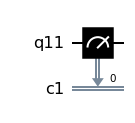

In [11]:
from qiskit.tools.visualization import circuit_drawer
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])
circuit_drawer(circuit, output = 'mpl')

This gives a quick sanity check to see whether we correctly implemented some circuit.

The second one shows the operation on the Bloch sphere, which is especially important for understanding how rotations happen. Qiskit has a built-in function to plot a state on the Bloch sphere. This visualization method relies on the state vector simulator backend. For instance, let's compare the initial state $|0\rangle$ and the Hadamard gate applied to it:

Initial state


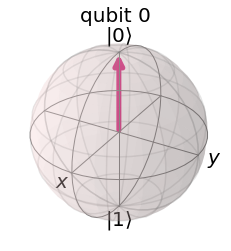

In [12]:
from qiskit.tools.visualization import plot_bloch_multivector
backend = Aer.get_backend('statevector_simulator')
circuit = QuantumCircuit(q, c)
circuit.i(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("Initial state")
plot_bloch_multivector(state)

After the Hadamard gate:

After a Hadamard gate


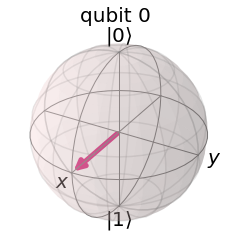

In [13]:
circuit.h(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("After a Hadamard gate")
plot_bloch_multivector(state)

The third way of visualizing what happens is plotting the statistics of measurement results. Arguably, this is the most important for practical applications and debugging. This visualization needs the `qasm_simulator` backend.

Initial state statistics


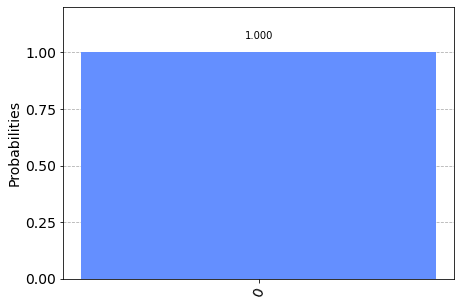

In [14]:
from qiskit.tools.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])
job = execute(circuit, backend, shots=1000)
print("Initial state statistics")
plot_histogram(job.result().get_counts(circuit))

Statistics if we apply a Hadamard gate


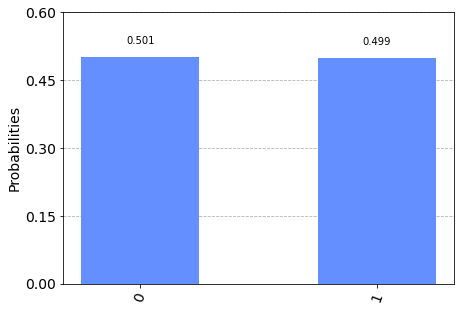

In [15]:
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q[0], c[0])
job = execute(circuit, backend, shots=1000)
print("Statistics if we apply a Hadamard gate")
plot_histogram(job.result().get_counts(circuit))

As we can see, the 'perfect' nature of the simulator is reflected again in getting all 0s for the initial state, and a distribution very close to uniform after applying the Hadamard gate. In a longer circuit on real quantum hardware, these statistics would be heavily affected by noise.